In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import STOPWORDS, WordCloud

In [2]:
df = pd.read_csv("../combined_df.csv")

In [3]:
# Step 1: Group by topic and count occurrences
topic_counts = df.groupby("Final Topic Name").size().reset_index(name="Count")

# Step 2: Calculate the total count and the percentage for each topic
total_count = topic_counts["Count"].sum()
topic_counts["Percentage"] = (topic_counts["Count"] / total_count) * 100

# Step 3: Filter for the top 3 topics by count
top_3_topics = topic_counts.nlargest(3, "Count")
topics_of_interest = top_3_topics["Final Topic Name"].tolist()

In [4]:
def calculate_indices(df, top_3_topics, years_of_interest):
    # Extract the top 3 topics as a list of topic names
    topics_of_interest = top_3_topics["Final Topic Name"].tolist()

    # Initialize DataFrame to store indices for hate and toxic classifications by year
    all_indices_df = pd.DataFrame()

    # Loop over each topic and year to calculate indices
    for topic in topics_of_interest:
        indices_data = {"Final Topic Name": topic}  # Initialize data for each topic

        for year in years_of_interest:
            # Filter data for each topic and year
            df_topic_year = df[(df["Final Topic Name"] == topic) & (df["year"] == year)]

            # Calculate the total hate and toxic counts for each topic and year
            total_hate_count = df_topic_year[
                df_topic_year["Classification"].str.startswith("Hate")
            ].shape[0]
            total_toxic_count = df_topic_year[
                df_topic_year["Classification"].str.startswith("Toxic")
            ].shape[0]

            # Calculate hate indices if there are hate comments for the year
            if total_hate_count > 0:
                indices_data.update(
                    {
                        f"Hate 1 Index {year}": df_topic_year[
                            df_topic_year["Classification"] == "Hate 1"
                        ].shape[0]
                        / total_hate_count,
                        f"Hate 2 Index {year}": df_topic_year[
                            df_topic_year["Classification"] == "Hate 2"
                        ].shape[0]
                        / total_hate_count,
                        f"Hate 3 Index {year}": df_topic_year[
                            df_topic_year["Classification"] == "Hate 3"
                        ].shape[0]
                        / total_hate_count,
                    }
                )

            # Calculate toxic indices if there are toxic comments for the year
            if total_toxic_count > 0:
                indices_data.update(
                    {
                        f"Toxic 1 Index {year}": df_topic_year[
                            df_topic_year["Classification"] == "Toxic 1"
                        ].shape[0]
                        / total_toxic_count,
                        f"Toxic 2 Index {year}": df_topic_year[
                            df_topic_year["Classification"] == "Toxic 2"
                        ].shape[0]
                        / total_toxic_count,
                        f"Toxic 3 Index {year}": df_topic_year[
                            df_topic_year["Classification"] == "Toxic 3"
                        ].shape[0]
                        / total_toxic_count,
                    }
                )

        # Append indices data for each topic
        indices_df = pd.DataFrame(
            [indices_data]
        )  # Wrap in list to create single-row DataFrame
        all_indices_df = pd.concat([all_indices_df, indices_df], ignore_index=True)

    # Fill NaN values with 0 for missing indices
    all_indices_df.fillna(0, inplace=True)

    return all_indices_df


# Usage
years_of_interest = [2020, 2021, 2022, 2023]
# Assuming top_3_topics and df are already defined
all_indices_df = calculate_indices(df, top_3_topics, years_of_interest)

# Display the final DataFrame with indices for each classification level and year
print(all_indices_df)

  Final Topic Name  Hate 1 Index 2020  Hate 2 Index 2020  Hate 3 Index 2020  \
0             Race           0.968009           0.030888           0.001103   
1           Crimes           0.897959           0.056122           0.045918   
2           Gender           0.980237           0.015810           0.003953   

   Toxic 1 Index 2020  Toxic 2 Index 2020  Toxic 3 Index 2020  \
0            0.807143            0.189286            0.003571   
1            0.623116            0.321608            0.055276   
2            0.759036            0.216867            0.024096   

   Hate 1 Index 2021  Hate 2 Index 2021  Hate 3 Index 2021  ...  \
0           0.971868           0.027253           0.000879  ...   
1           0.888889           0.088889           0.022222  ...   
2           0.984940           0.012048           0.003012  ...   

   Hate 3 Index 2022  Toxic 1 Index 2022  Toxic 2 Index 2022  \
0           0.002759            0.661053            0.324211   
1           0.057508     

In [5]:
def calculate_trend_data(all_indices_df, topics_of_interest):
    trend_data = []
    for topic in topics_of_interest:
        # Filter rows in all_indices_df to get the relevant indices for the topic
        topic_data = all_indices_df[all_indices_df["Final Topic Name"] == topic]

        if topic_data.empty:
            print(f"No data found for topic: {topic}")
            continue
        try:
            trend = {"Final Topic Name": topic}

            # Loop over the indices and calculate changes for each level and year
            for index_type in ["Hate", "Toxic"]:
                for level in ["1", "2", "3"]:
                    # Check if columns exist for each year and retrieve values safely
                    index_2020 = topic_data.get(
                        f"{index_type} {level} Index 2020", pd.Series([None])
                    ).values[0]
                    index_2021 = topic_data.get(
                        f"{index_type} {level} Index 2021", pd.Series([None])
                    ).values[0]
                    index_2022 = topic_data.get(
                        f"{index_type} {level} Index 2022", pd.Series([None])
                    ).values[0]
                    index_2023 = topic_data.get(
                        f"{index_type} {level} Index 2023", pd.Series([None])
                    ).values[0]

                    # Calculate percentage changes between years if indices are available
                    trend[f"{index_type} {level} % Change 2020-2021"] = (
                        ((index_2021 - index_2020) / index_2020 * 100)
                        if index_2020
                        else 0
                    )
                    trend[f"{index_type} {level} % Change 2021-2022"] = (
                        ((index_2022 - index_2021) / index_2021 * 100)
                        if index_2021
                        else 0
                    )
                    trend[f"{index_type} {level} % Change 2022-2023"] = (
                        ((index_2023 - index_2022) / index_2022 * 100)
                        if index_2022
                        else 0
                    )

            # Append the trend data for the topic
            trend_data.append(trend)

        except (IndexError, KeyError) as e:
            print(f"Error processing data for topic: {topic} - {e}")

    # Convert trend data to a DataFrame
    trend_df = pd.DataFrame(trend_data)

    return trend_df


# Usage
trend_df = calculate_trend_data(all_indices_df, topics_of_interest)

# Display the trend DataFrame
print(trend_df)

  Final Topic Name  Hate 1 % Change 2020-2021  Hate 1 % Change 2021-2022  \
0             Race                   0.398685                  -1.410398   
1           Crimes                  -1.010101                  -2.595847   
2           Gender                   0.479742                  -0.727149   

   Hate 1 % Change 2022-2023  Hate 2 % Change 2020-2021  \
0                  -0.541081                 -11.769231   
1                  -2.347054                  58.383838   
2                   0.680934                 -23.795181   

   Hate 2 % Change 2021-2022  Hate 2 % Change 2022-2023  \
0                  43.400074                  12.644558   
1                 -13.738019                  28.737482   
2                  22.962963                   5.058366   

   Hate 3 % Change 2020-2021  Hate 3 % Change 2021-2022  \
0                 -20.307692                 213.793103   
1                 -51.604938                 158.785942   
2                 -23.795181                

In [6]:
# Function to calculate net trend for Hate and Toxic columns


def calculate_net_trend(columns):
    """
    Calculate the net trend based on the given columns.
    We calculate it by summing the weighted percentages.
    """
    return sum([columns[i] * (3 - i) for i in range(3)])


def calculate_net_trends(trend_df):
    # Extract the years dynamically from the column names
    years = sorted(
        set([col.split()[-1] for col in trend_df.columns if "Change" in col])
    )

    # Identify the Hate and Toxic columns
    hate_columns = [
        col for col in trend_df.columns if "Hate" in col and "Change" in col
    ]
    toxic_columns = [
        col for col in trend_df.columns if "Toxic" in col and "Change" in col
    ]

    # List to hold the new data
    net_trend_data = []

    # Loop through each topic to calculate the net trends
    for topic in trend_df["Final Topic Name"]:
        topic_data = trend_df[trend_df["Final Topic Name"] == topic]

        if not topic_data.empty:
            try:
                # Initialize a dictionary to store results for each year
                net_trends = {"Final Topic Name": topic}

                # Loop through each year and calculate net trends for Hate and Toxic
                for year in years:
                    # Initialize lists to store the Hate and Toxic data
                    hate_data = []
                    toxic_data = []

                    # Extract Hate data for the current year
                    for col in hate_columns:
                        if year in col:
                            hate_value = topic_data.get(col, pd.Series([None])).values[
                                0
                            ]
                            hate_data.append(
                                hate_value if hate_value is not None else 0
                            )

                    # Extract Toxic data for the current year
                    for col in toxic_columns:
                        if year in col:
                            toxic_value = topic_data.get(col, pd.Series([None])).values[
                                0
                            ]
                            toxic_data.append(
                                toxic_value if toxic_value is not None else 0
                            )

                    # Calculate net trends for Hate and Toxic
                    net_trends[f"Net Hate Trend {year}"] = calculate_net_trend(
                        hate_data
                    )
                    net_trends[f"Net Toxic Trend {year}"] = calculate_net_trend(
                        toxic_data
                    )

                # Append the calculated net trends for the topic
                net_trend_data.append(net_trends)

            except Exception as e:
                print(f"Error processing data for topic: {topic} - {e}")

    # Create DataFrame to display the net trend data
    net_trend_df = pd.DataFrame(net_trend_data)

    # Merge the net trend data with the original trend_df based on the 'Final Topic Name'
    final_trend_df = pd.merge(trend_df, net_trend_df, on="Final Topic Name", how="left")

    return final_trend_df


# Assuming trend_df is your DataFrame with topic data
final_trend_df = calculate_net_trends(trend_df)

# Display the final DataFrame with net trend data
print(final_trend_df)

  Final Topic Name  Hate 1 % Change 2020-2021  Hate 1 % Change 2021-2022  \
0             Race                   0.398685                  -1.410398   
1           Crimes                  -1.010101                  -2.595847   
2           Gender                   0.479742                  -0.727149   

   Hate 1 % Change 2022-2023  Hate 2 % Change 2020-2021  \
0                  -0.541081                 -11.769231   
1                  -2.347054                  58.383838   
2                   0.680934                 -23.795181   

   Hate 2 % Change 2021-2022  Hate 2 % Change 2022-2023  \
0                  43.400074                  12.644558   
1                 -13.738019                  28.737482   
2                  22.962963                   5.058366   

   Hate 3 % Change 2020-2021  Hate 3 % Change 2021-2022  \
0                 -20.307692                 213.793103   
1                 -51.604938                 158.785942   
2                 -23.795181                

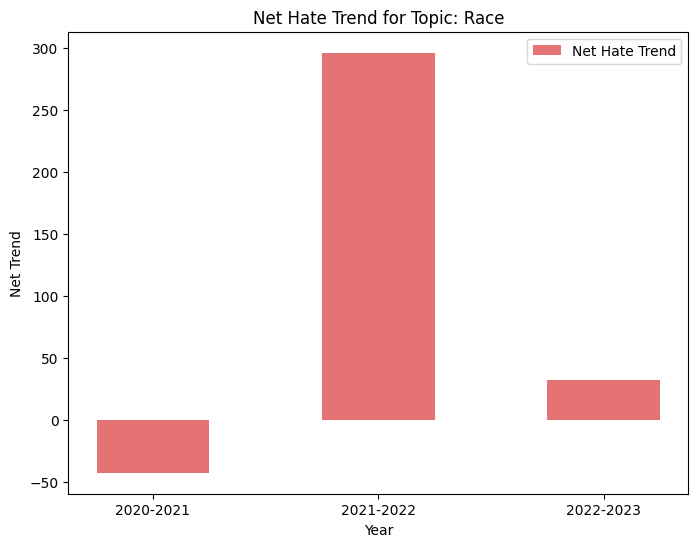

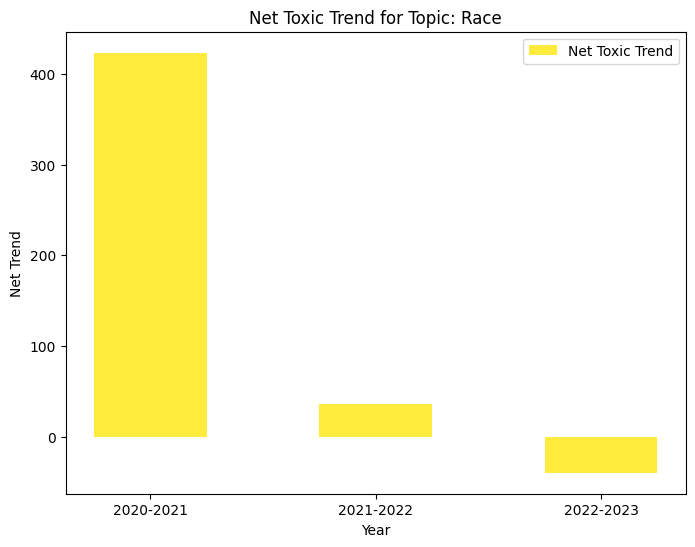

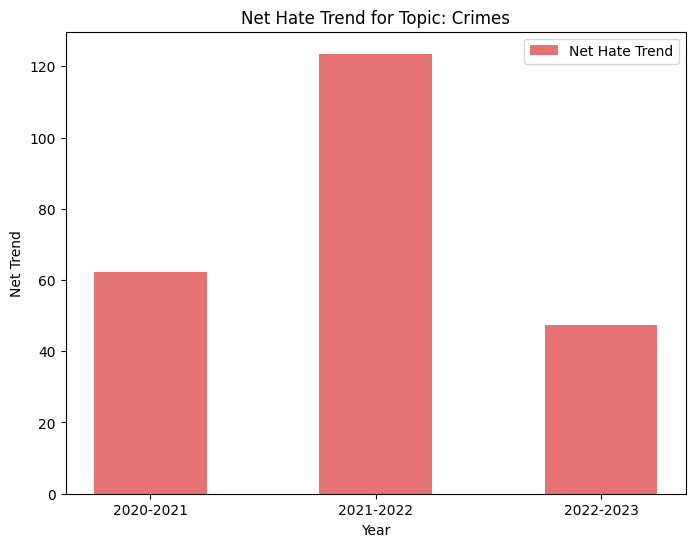

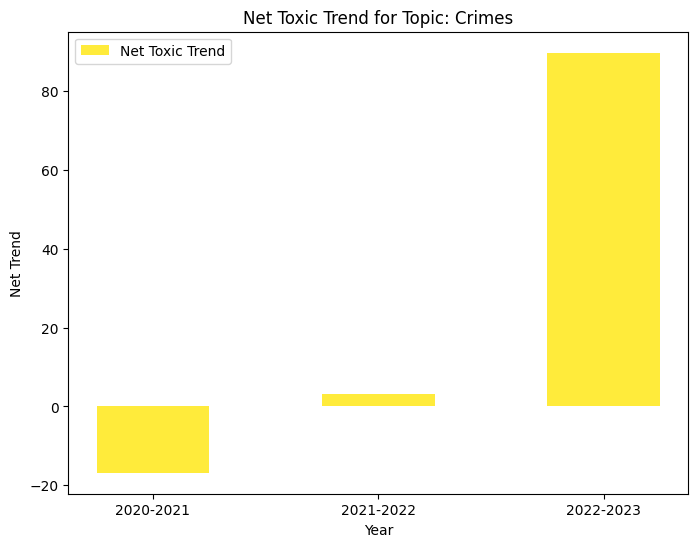

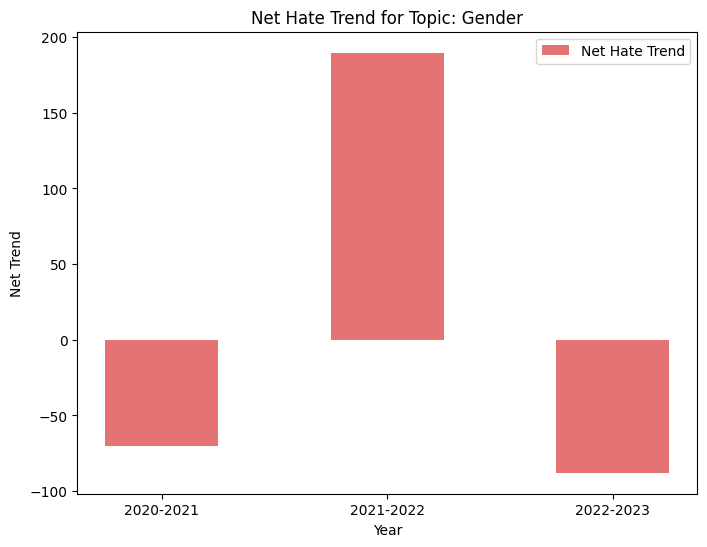

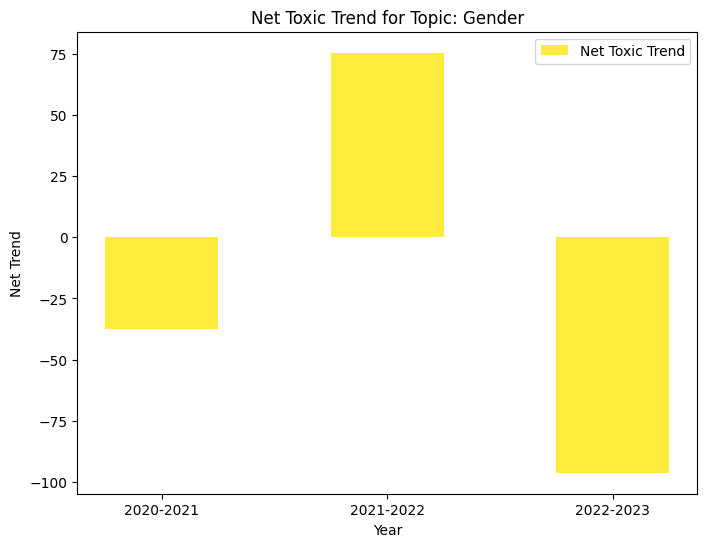

In [7]:
def extract_years(final_trend_df):
    # Identify columns with 'Net Hate Trend' or 'Net Toxic Trend' to determine the years dynamically
    trend_columns = [
        col
        for col in final_trend_df.columns
        if "Net Hate Trend" in col or "Net Toxic Trend" in col
    ]
    years = sorted({col.split()[-1] for col in trend_columns})
    return years


# Function to plot net trends for Hate and Toxic


def plot_net_trends(final_trend_df):
    years = extract_years(
        final_trend_df
    )  # Dynamically extract years from the DataFrame columns

    for index, row in final_trend_df.iterrows():
        # Extract the topic name and the corresponding net trends
        topic = row["Final Topic Name"]
        hate_trends = [row.get(f"Net Hate Trend {year}", 0) for year in years]
        toxic_trends = [row.get(f"Net Toxic Trend {year}", 0) for year in years]

        # Create the Net Hate Trend bar plot
        fig, ax = plt.subplots(figsize=(8, 6))
        x = np.arange(len(years))  # Positions for the bars
        width = 0.5  # Bar width

        ax.bar(
            x, hate_trends, width, label="Net Hate Trend", color="#E57373"
        )  # Softer red
        ax.set_title(f"Net Hate Trend for Topic: {topic}")
        ax.set_xlabel("Year")
        ax.set_ylabel("Net Trend")
        ax.set_xticks(x)
        ax.set_xticklabels(years)
        ax.legend()
        plt.show()

        # Create the Net Toxic Trend bar plot
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.bar(
            x, toxic_trends, width, label="Net Toxic Trend", color="#FFEB3B"
        )  # Warm yellow
        ax.set_title(f"Net Toxic Trend for Topic: {topic}")
        ax.set_xlabel("Year")
        ax.set_ylabel("Net Trend")
        ax.set_xticks(x)
        ax.set_xticklabels(years)
        ax.legend()
        plt.show()


# Usage
plot_net_trends(final_trend_df)

In [8]:
def filter_positive_years_separately(final_trend_df):
    positive_trend_data = []
    years = extract_years(final_trend_df)  # Dynamically extract years from columns

    # Loop through each row in the DataFrame
    for index, row in final_trend_df.iterrows():
        # Extract the topic name
        topic = row["Final Topic Name"]

        # Initialize dictionaries to store the positive years for Hate and Toxic separately
        positive_hate_years = {"Final Topic Name": topic}
        positive_toxic_years = {"Final Topic Name": topic}

        # Loop through each year and check if the Net Hate and Net Toxic trends are positive
        for year in years:
            # Check if Net Hate Trend is positive for the year
            if row.get(f"Net Hate Trend {year}", 0) > 0:
                positive_hate_years[f"Positive Hate Year {year}"] = True
            else:
                positive_hate_years[f"Positive Hate Year {year}"] = False

            # Check if Net Toxic Trend is positive for the year
            if row.get(f"Net Toxic Trend {year}", 0) > 0:
                positive_toxic_years[f"Positive Toxic Year {year}"] = True
            else:
                positive_toxic_years[f"Positive Toxic Year {year}"] = False

        # Append the result for this topic to the list
        positive_trend_data.append({**positive_hate_years, **positive_toxic_years})

    # Create a DataFrame from the list of positive trend data
    positive_trend_df = pd.DataFrame(positive_trend_data)

    return positive_trend_df


# Usage
positive_trend_df = filter_positive_years_separately(final_trend_df)

# Display the filtered DataFrame
print(positive_trend_df)

  Final Topic Name  Positive Hate Year 2020-2021  \
0             Race                         False   
1           Crimes                          True   
2           Gender                         False   

   Positive Hate Year 2021-2022  Positive Hate Year 2022-2023  \
0                          True                          True   
1                          True                          True   
2                          True                         False   

   Positive Toxic Year 2020-2021  Positive Toxic Year 2021-2022  \
0                           True                           True   
1                          False                           True   
2                          False                           True   

   Positive Toxic Year 2022-2023  
0                          False  
1                           True  
2                          False  


In [9]:
def get_comments_for_positive_years(final_trend_df, comments_df, topics_of_interest):
    # Initialize dictionaries to store filtered comments for each topic, split by Hate and Toxic
    filtered_hate_comments_dict = {}
    filtered_toxic_comments_dict = {}

    # Extract years from column names in final_trend_df (columns that start with 'Positive Hate Year' or 'Positive Toxic Year')
    years = sorted(
        set(col.split()[-1] for col in final_trend_df.columns if "Positive" in col)
    )

    # Loop through each topic in the topics_of_interest list
    for topic in topics_of_interest:
        # Filter rows in final_trend_df for the current topic
        topic_data = final_trend_df[final_trend_df["Final Topic Name"] == topic]

        # Initialize lists to collect comments per year where trends are positive
        hate_comments = []
        toxic_comments = []

        # If topic data is available
        if not topic_data.empty:
            # Loop through each year to check if any trend is positive for the specific year
            for year in years:
                # Extract the relevant years from the year range (e.g., "2020-2021" corresponds to 2020 and 2021)
                start_year, end_year = map(int, year.split("-"))

                # Check for positive trend in Hate for this year range
                positive_hate_column = f"Positive Hate Year {year}"
                if (
                    positive_hate_column in topic_data.columns
                    and topic_data[positive_hate_column].iloc[0]
                ):
                    hate_comments_in_years = comments_df[
                        (comments_df["year"] > start_year)
                        & (comments_df["year"] <= end_year)
                        & (comments_df["Final Topic Name"] == topic)
                        & (comments_df["Classification"].str.startswith("Hate"))
                    ]
                    hate_comments.append(hate_comments_in_years)

                # Check for positive trend in Toxic for this year range
                positive_toxic_column = f"Positive Toxic Year {year}"
                if (
                    positive_toxic_column in topic_data.columns
                    and topic_data[positive_toxic_column].iloc[0]
                ):
                    toxic_comments_in_years = comments_df[
                        (comments_df["year"] > start_year)
                        & (comments_df["year"] <= end_year)
                        & (comments_df["Final Topic Name"] == topic)
                        & (comments_df["Classification"].str.startswith("Toxic"))
                    ]
                    toxic_comments.append(toxic_comments_in_years)

            # Combine the filtered comments into a single DataFrame for each category if there are any comments
            if hate_comments:
                filtered_hate_comments_df = pd.concat(hate_comments, ignore_index=True)
                filtered_hate_comments_dict[topic] = filtered_hate_comments_df
            if toxic_comments:
                filtered_toxic_comments_df = pd.concat(
                    toxic_comments, ignore_index=True
                )
                filtered_toxic_comments_dict[topic] = filtered_toxic_comments_df

    return filtered_hate_comments_dict, filtered_toxic_comments_dict


# Usage example
topics_of_interest = ["Race", "Crimes", "Gender"]
filtered_hate_comments_dict, filtered_toxic_comments_dict = (
    get_comments_for_positive_years(positive_trend_df, df, topics_of_interest)
)

# Access individual DataFrames for each topic in both Hate and Toxic categories
race_hate_comments_df = filtered_hate_comments_dict.get(
    "Race", pd.DataFrame()
)  # Returns empty DataFrame if topic is not found
race_toxic_comments_df = filtered_toxic_comments_dict.get("Race", pd.DataFrame())


crimes_hate_comments_df = filtered_hate_comments_dict.get("Crimes", pd.DataFrame())
crimes_toxic_comments_df = filtered_toxic_comments_dict.get("Crimes", pd.DataFrame())

gender_hate_comments_df = filtered_hate_comments_dict.get("Gender", pd.DataFrame())
gender_toxic_comments_df = filtered_toxic_comments_dict.get("Gender", pd.DataFrame())

# Display example output for verification
print("Race Hate Comments DataFrame with Positive Net Hate Trend:")
print(race_hate_comments_df)

print("\nRace Toxic Comments DataFrame with Positive Net Toxic Trend:")
print(race_toxic_comments_df)

Race Hate Comments DataFrame with Positive Net Hate Trend:
                                                   text         timestamp  \
0     In America, people from a certain race are the...   30/8/2022 11:52   
1     Nothing shocking. This is how most Chinese boo...    16/7/2022 1:25   
2     you're extremely insecure, what's your ethnici...   22/11/2022 6:05   
3     In the same way we think RM12 is cheap for foo...    20/9/2022 3:12   
4     Ji boliao Singaporeans. This one swastika logo...    28/7/2022 3:33   
...                                                 ...               ...   
4169  Lol the jealousy.Your women still would throw ...    5/6/2023 10:40   
4170                      Why do they all look the same  22/10/2023 16:59   
4171  One of those side effect is that it makes the ...   7/13/2023 10:09   
4172  Ask Jianhao Tan who living in his landed funde...    10/2/2023 2:05   
4173  Am Chinese Malaysian, life sucks in Malaysia b...    11/8/2023 2:40   

               u

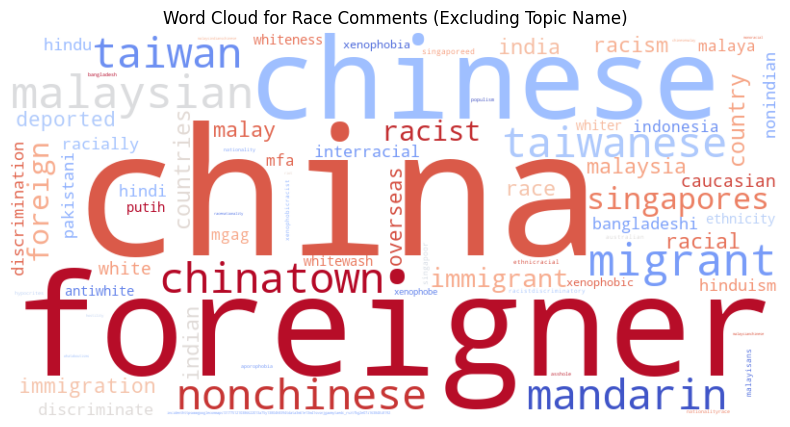

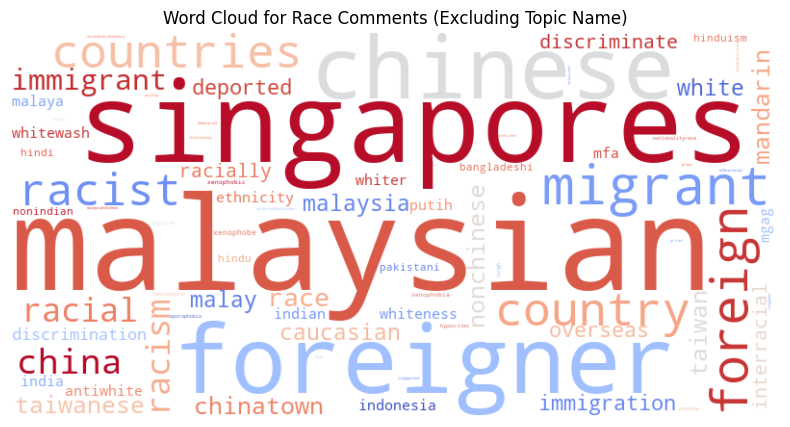

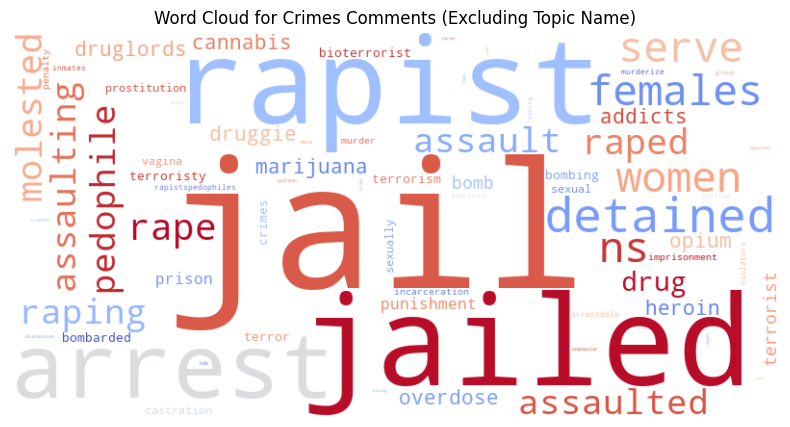

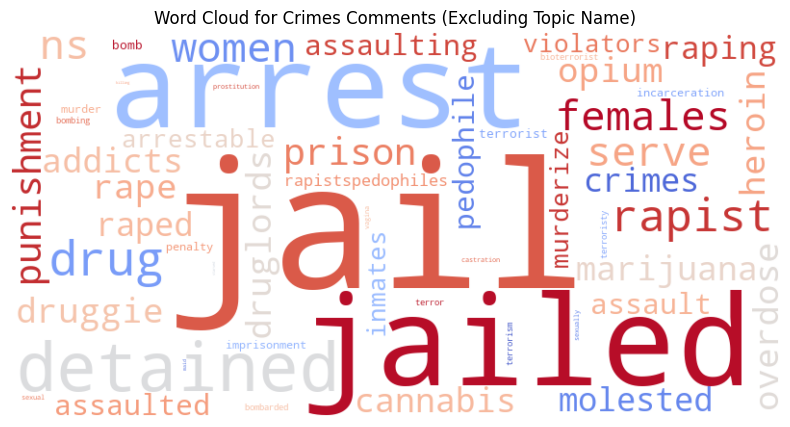

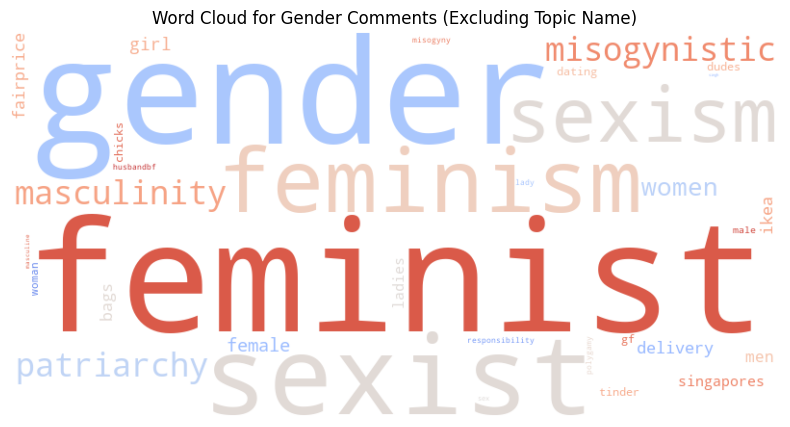

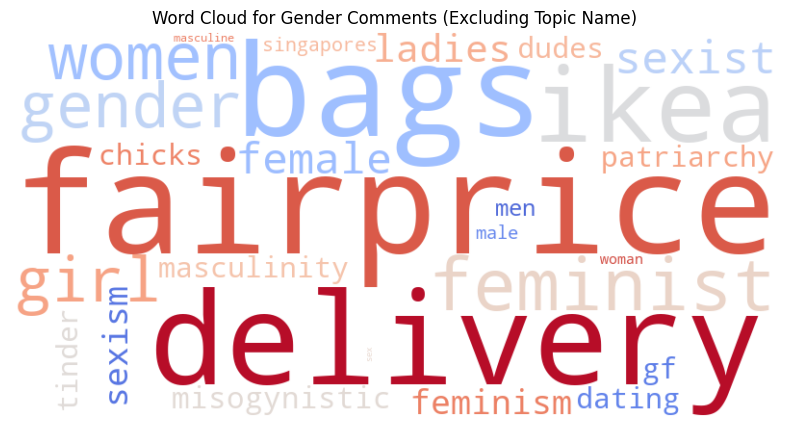

In [ ]:
custom_stopwords = {
    "comment",
    "say",
    "singapore",
    "singaporean",
    "people",
    "singaporeans",
    "u",
    "even",
    "will",
    "one",
    "lol",
    "go",
    "singapores",
    "malaysian"
}


def generate_wordcloud(df, topic_name, custom_stopwords=custom_stopwords):
    """
    Generates a word cloud for a specific topic across all years present in the DataFrame,
    excluding the topic name from the words.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    topic_name (str): The topic to filter by.
    custom_stopwords (set, optional): Additional stopwords to exclude.

    Returns:
    None: Displays the word cloud plot for each year.
    """
    # Create a set of stopwords combining default STOPWORDS with the custom stopwords
    stopwords = set(STOPWORDS)
    if custom_stopwords:
        stopwords.update(custom_stopwords)

    # Filter the DataFrame for the specified topic
    topic_comments = df[df["Final Topic Name"] == topic_name]

    if not topic_comments.empty:
        # Combine all the Topic_Words into one string
        topic_text = " ".join(topic_comments["Topic_Words"].dropna())

        # Exclude the topic name from the text (e.g., "Hate - Race" or "Toxic - Race")
        topic_text = topic_text.replace(topic_name, "")

        # Generate the word cloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color="white",
            collocations=False,
            stopwords=stopwords,
            colormap="coolwarm",
            random_state=478,
        ).generate(topic_text)

        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for {topic_name} Comments (Excluding Topic Name)")
        plt.show()


# Example usage
dataframes = [
    (race_hate_comments_df, "Race"),
    (race_toxic_comments_df, "Race"),
    (crimes_hate_comments_df, "Crimes"),
    (crimes_toxic_comments_df, "Crimes"),
    (gender_hate_comments_df, "Gender"),
    (gender_toxic_comments_df, "Gender"),
]

# Generate word clouds for each DataFrame
for df, topic_name in dataframes:
    generate_wordcloud(df, topic_name)

# generate_wordcloud(df,topic_name)

getting final df for problem statement generation

In [11]:
def filter_and_sequence_comments(df, n=20):
    """
    Filters the DataFrame based on the most frequently occurring exact 'Topic_Words' list,
    extracts the title from the URL, and sequences comments by intensity level within that subset.

    Parameters:
    df (DataFrame): The DataFrame containing comments.
    n (int): The number of top comments to return after filtering and sequencing.

    Returns:
    DataFrame: Filtered and sequenced DataFrame based on the most frequent 'Topic_Words' list as a whole and intensity.
    """

    # Step 1: Count the occurrences of each unique list in 'Topic_Words'
    topic_words_counts = df["Topic_Words"].apply(tuple).value_counts()

    # Step 2: Identify the most frequently occurring 'Topic_Words' list as a whole
    if not topic_words_counts.empty:
        top_topic_words = (
            topic_words_counts.idxmax()
        )  # The most common list (as a tuple)
    else:
        return pd.DataFrame()  # Return empty DataFrame if no entries found

    # Step 3: Filter the DataFrame for rows that match the most frequent 'Topic_Words' list exactly
    filtered_df = df[df["Topic_Words"].apply(tuple) == top_topic_words].copy()

    # Step 4: Extract intensity levels from 'Classification' column
    filtered_df["Intensity"] = (
        filtered_df["Classification"].str.extract(r"(\d)").astype(float)
    )

    # Step 5: Set default intensity order and sort
    intensity_order = [3, 2, 1]
    filtered_df["Intensity"] = pd.Categorical(
        filtered_df["Intensity"], categories=intensity_order, ordered=True
    )
    filtered_df = filtered_df.sort_values(by="Intensity")

    # Step 6: Extract the title from the URL and add as 'Reddit Title' column
    # Extract the segment between '/comments/' and the following '/'
    filtered_df["Reddit Title"] = filtered_df["link"].str.extract(
        r"/comments/\w+/([^/]+)/"
    )
    filtered_df["Reddit Title"] = filtered_df["Reddit Title"].str.replace(
        "_", " "
    )  # Replace underscores with spaces for readability

    # Drop the temporary 'Intensity' column
    filtered_df = filtered_df.drop(columns=["Intensity"])

    # Return only the top `n` rows
    return filtered_df.head(n)


# `race_hate_comments_df` and `race_toxic_comments_df` are pre-filtered DataFrames

# For Hate comments related to Race
increase_race_hate_comments = filter_and_sequence_comments(race_hate_comments_df)
# For Toxic comments related to Race
increase_race_toxic_comments = filter_and_sequence_comments(race_toxic_comments_df)
# For Hate comments related to Crimes
increase_crimes_hate_comments = filter_and_sequence_comments(crimes_hate_comments_df)
# For Toxic comments related to Race
increase_crimes_toxic_comments = filter_and_sequence_comments(crimes_toxic_comments_df)
# For Hate comments related to Crimes
increase_gender_hate_comments = filter_and_sequence_comments(gender_hate_comments_df)
# For Toxic comments related to Race
increase_gender_toxic_comments = filter_and_sequence_comments(gender_toxic_comments_df)

In [12]:
increase_race_hate_comments.to_csv("increase_race_hate_comments.csv", index=False)
increase_race_toxic_comments.to_csv("increase_race_toxic_comments.csv", index=False)
increase_crimes_hate_comments.to_csv("increase_crimes_hate_comments.csv", index=False)
increase_crimes_toxic_comments.to_csv("increase_crimes_toxic_comments.csv", index=False)
increase_gender_hate_comments.to_csv("increase_gender_hate_comments.csv", index=False)
increase_gender_toxic_comments.to_csv("increase_gender_toxic_comments.csv", index=False)

## To Find Decrease Subtopics

In [13]:
df = pd.read_csv("../combined_df.csv")

In [14]:
def filter_negative_years_separately(final_trend_df):
    negative_trend_data = []
    years = extract_years(final_trend_df)  # Dynamically extract years from columns

    # Loop through each row in the DataFrame
    for index, row in final_trend_df.iterrows():
        # Extract the topic name
        topic = row["Final Topic Name"]

        # Initialize dictionaries to store the negative years for Hate and Toxic separately
        negative_hate_years = {"Final Topic Name": topic}
        negative_toxic_years = {"Final Topic Name": topic}

        # Loop through each year and check if the Net Hate and Net Toxic trends are negative
        for year in years:
            # Check if Net Hate Trend is negative for the year
            if row.get(f"Net Hate Trend {year}", 0) < 0:
                negative_hate_years[f"Negative Hate Year {year}"] = True
            else:
                negative_hate_years[f"Negative Hate Year {year}"] = False

            # Check if Net Toxic Trend is negative for the year
            if row.get(f"Net Toxic Trend {year}", 0) < 0:
                negative_toxic_years[f"Negative Toxic Year {year}"] = True
            else:
                negative_toxic_years[f"Negative Toxic Year {year}"] = False

        # Append the result for this topic to the list
        negative_trend_data.append({**negative_hate_years, **negative_toxic_years})

    # Create a DataFrame from the list of negative trend data
    negative_trend_df = pd.DataFrame(negative_trend_data)

    return negative_trend_df


# Usage
negative_trend_df = filter_negative_years_separately(final_trend_df)

# Display the filtered DataFrame
print(negative_trend_df)

  Final Topic Name  Negative Hate Year 2020-2021  \
0             Race                          True   
1           Crimes                         False   
2           Gender                          True   

   Negative Hate Year 2021-2022  Negative Hate Year 2022-2023  \
0                         False                         False   
1                         False                         False   
2                         False                          True   

   Negative Toxic Year 2020-2021  Negative Toxic Year 2021-2022  \
0                          False                          False   
1                           True                          False   
2                           True                          False   

   Negative Toxic Year 2022-2023  
0                           True  
1                          False  
2                           True  


In [15]:
def get_comments_for_negative_years(final_trend_df, comments_df, topics_of_interest):
    # Initialize dictionaries to store filtered comments for each topic, split by Hate and Toxic
    filtered_hate_comments_dict = {}
    filtered_toxic_comments_dict = {}

    # Get negative trends for each topic using the previously defined function
    negative_trend_df = filter_negative_years_separately(final_trend_df)

    # Extract years from column names in negative_trend_df (columns that start with 'Negative Hate Year' or 'Negative Toxic Year')
    years = sorted(
        set(col.split()[-1] for col in negative_trend_df.columns if "Negative" in col)
    )

    # Loop through each topic in the topics_of_interest list
    for topic in topics_of_interest:
        # Check if the topic exists in negative_trend_df
        topic_data = negative_trend_df[negative_trend_df["Final Topic Name"] == topic]

        # Initialize lists to collect comments per year where trends are negative (i.e., 'Negative' column is True)
        hate_comments = []
        toxic_comments = []

        # If topic data is available
        if not topic_data.empty:
            # Loop through each year to check if the trend is negative (i.e., 'Negative' is True for that year)
            for year in years:
                # Extract the relevant years from the year range (e.g., "2020-2021" corresponds to 2020 and 2021)
                start_year, end_year = map(int, year.split("-"))

                # Check if the 'Negative Hate Year' is True for this year range (negative trend)
                if topic_data.get(f"Negative Hate Year {year}", False).values[0]:
                    hate_comments_in_years = comments_df[
                        (comments_df["year"] > start_year)
                        & (comments_df["year"] <= end_year)
                        & (comments_df["Final Topic Name"] == topic)
                        & (comments_df["Classification"].str.startswith("Hate"))
                    ]
                    hate_comments.append(hate_comments_in_years)

                # Check if the 'Negative Toxic Year' is True for this year range (negative trend)
                if topic_data.get(f"Negative Toxic Year {year}", False).values[0]:
                    toxic_comments_in_years = comments_df[
                        (comments_df["year"] > start_year)
                        & (comments_df["year"] <= end_year)
                        & (comments_df["Final Topic Name"] == topic)
                        & (comments_df["Classification"].str.startswith("Toxic"))
                    ]
                    toxic_comments.append(toxic_comments_in_years)

            # Combine the filtered comments into a single DataFrame for each category if there are any comments
            if hate_comments:
                filtered_hate_comments_df = pd.concat(hate_comments, ignore_index=True)
                filtered_hate_comments_dict[topic] = filtered_hate_comments_df
            if toxic_comments:
                filtered_toxic_comments_df = pd.concat(
                    toxic_comments, ignore_index=True
                )
                filtered_toxic_comments_dict[topic] = filtered_toxic_comments_df

    return filtered_hate_comments_dict, filtered_toxic_comments_dict


# Usage example
topics_of_interest = ["Race", "Crimes", "Gender"]
filtered_hate_comments_dict, filtered_toxic_comments_dict = (
    get_comments_for_negative_years(final_trend_df, df, topics_of_interest)
)

# Access individual DataFrames for each topic in both Hate and Toxic categories
decrease_race_hate_comments = filtered_hate_comments_dict.get("Race", pd.DataFrame())
decrease_race_toxic_comments = filtered_toxic_comments_dict.get("Race", pd.DataFrame())

## decrease_crimes_hate_comments_df = filtered_hate_comments_dict.get('Crimes', pd.DataFrame())--> empty
decrease_crimes_toxic_comments = filtered_toxic_comments_dict.get(
    "Crimes", pd.DataFrame()
)

decrease_gender_hate_comments = filtered_hate_comments_dict.get(
    "Gender", pd.DataFrame()
)
decrease_gender_toxic_comments = filtered_toxic_comments_dict.get(
    "Gender", pd.DataFrame()
)

In [16]:
def filter_and_sequence_comments(df, n=20):
    """
    Filters the DataFrame based on the most frequently occurring exact 'Topic_Words' list,
    extracts the title from the URL, and sequences comments by intensity level within that subset.

    Parameters:
    df (DataFrame): The DataFrame containing comments.
    n (int): The number of top comments to return after filtering and sequencing.

    Returns:
    DataFrame: Filtered and sequenced DataFrame based on the most frequent 'Topic_Words' list as a whole and intensity.
    """

    # Step 1: Count the occurrences of each unique list in 'Topic_Words'
    topic_words_counts = df["Topic_Words"].apply(tuple).value_counts()

    # Step 2: Identify the most frequently occurring 'Topic_Words' list as a whole
    if not topic_words_counts.empty:
        top_topic_words = (
            topic_words_counts.idxmax()
        )  # The most common list (as a tuple)
    else:
        return pd.DataFrame()  # Return empty DataFrame if no entries found

    # Step 3: Filter the DataFrame for rows that match the most frequent 'Topic_Words' list exactly
    filtered_df = df[df["Topic_Words"].apply(tuple) == top_topic_words].copy()

    # Step 4: Extract intensity levels from 'Classification' column
    filtered_df["Intensity"] = (
        filtered_df["Classification"].str.extract(r"(\d)").astype(float)
    )

    # Step 5: Set default intensity order and sort
    intensity_order = [3, 2, 1]
    filtered_df["Intensity"] = pd.Categorical(
        filtered_df["Intensity"], categories=intensity_order, ordered=True
    )
    filtered_df = filtered_df.sort_values(by="Intensity")

    # Step 6: Extract the title from the URL and add as 'Reddit Title' column
    # Extract the segment between '/comments/' and the following '/'
    filtered_df["Reddit Title"] = filtered_df["link"].str.extract(
        r"/comments/\w+/([^/]+)/"
    )
    filtered_df["Reddit Title"] = filtered_df["Reddit Title"].str.replace(
        "_", " "
    )  # Replace underscores with spaces for readability

    # Drop the temporary 'Intensity' column
    filtered_df = filtered_df.drop(columns=["Intensity"])

    # Return only the top `n` rows
    return filtered_df.head(n)


# `race_hate_comments_df` and `race_toxic_comments_df` are pre-filtered DataFrames

# For Hate comments related to Race
decrease_race_hate_comments_df = filter_and_sequence_comments(
    decrease_race_hate_comments
)
# For Toxic comments related to Race
decrease_race_toxic_comments_df = filter_and_sequence_comments(
    decrease_race_toxic_comments
)
# For Hate comments related to Crimes--> do not have
# decrease_crimes_hate_comments_df = filter_and_sequence_comments(decrease_crimes_hate_comments)
# For Toxic comments related to Race
decrease_crimes_toxic_comments_df = filter_and_sequence_comments(
    decrease_crimes_toxic_comments
)
# For Hate comments related to Crimes
decrease_gender_hate_comments_df = filter_and_sequence_comments(
    decrease_gender_hate_comments
)
# For Toxic comments related to Race
decrease_gender_toxic_comments_df = filter_and_sequence_comments(
    decrease_gender_toxic_comments
)

In [17]:
decrease_gender_hate_comments_2021_df = decrease_gender_hate_comments_df[
    decrease_gender_hate_comments_df["year"] == 2021
]
decrease_gender_hate_comments_2023_df = decrease_gender_hate_comments_df[
    decrease_gender_hate_comments_df["year"] == 2023
]

# Filter for 2021 and 2023 for gender-related toxic comments
decrease_gender_toxic_comments_2021_df = decrease_gender_toxic_comments_df[
    decrease_gender_toxic_comments_df["year"] == 2021
]
decrease_gender_toxic_comments_2023_df = decrease_gender_toxic_comments_df[
    decrease_gender_toxic_comments_df["year"] == 2023
]

In [19]:
decrease_gender_hate_comments_2021_df.to_csv(
    "decrease_gender_hate_comments_2021.csv", index=False
)
decrease_gender_hate_comments_2023_df.to_csv(
    "decrease_gender_hate_comments_2023.csv", index=False
)
decrease_gender_toxic_comments_2021_df.to_csv(
    "decrease_gender_toxic_comments_2021.csv", index=False
)
decrease_gender_toxic_comments_2023_df.to_csv(
    "decrease_gender_toxic_comments_2023.csv", index=False
)
decrease_race_hate_comments_df.to_csv("decrease_race_hate_comments.csv", index=False)
decrease_race_toxic_comments_df.to_csv("decrease_race_toxic_comments.csv", index=False)
decrease_crimes_toxic_comments_df.to_csv(
    "decrease_crimes_toxic_comments.csv", index=False
)